In [24]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 100

In [26]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Soil_Detection/dataset/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1300 files belonging to 5 classes.


In [27]:
class_names=dataset.class_names
class_names

['Alluvial soil', 'Black soil', 'Clay soil', 'Garbage', 'Red soil']

(32, 256, 256, 3)
[4 0 0 2 0 3 0 3 1 2 3 3 3 1 4 4 2 1 0 0 2 4 3 3 1 2 0 3 4 0 4 4]


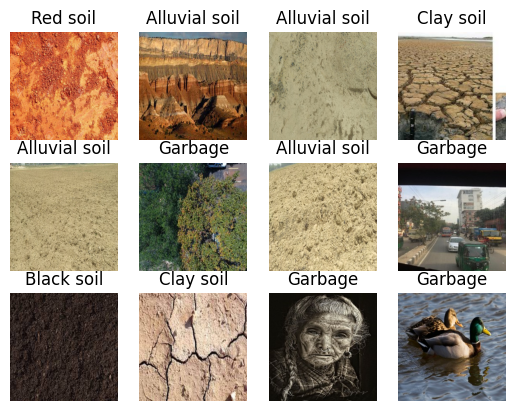

In [28]:
for image_batch,layers_batch in dataset.take(1):
    print(image_batch.shape)
    print(layers_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[layers_batch[i]])
        plt.axis("off")

In [29]:
len(dataset)

41

In [30]:
84*32

2688

In [31]:
def get_dataset_partition_tf(ds, train_spilt=0.6,val_spilt=0.2,test_spilt=0.2,shuffle=True,shuffle_size=10000):
    assert(train_spilt+val_spilt+test_spilt) == 1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*train_spilt)
    val_size=int(ds_size*val_spilt)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [32]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [33]:
len(train_ds)

24

In [34]:
len(val_ds)

8

In [35]:
len(test_ds)

9

In [36]:
(67*32)+(8*32)+(9*32)

2688

In [37]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
for image_batch, layers_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.33333334 0.2901961  0.26666668]
  [0.30980393 0.26666668 0.24313726]
  [0.24705882 0.20392157 0.18039216]
  ...
  [0.22745098 0.18431373 0.16078432]
  [0.21176471 0.16862746 0.14509805]
  [0.20392157 0.16078432 0.13725491]]

 [[0.2901961  0.24705882 0.22352941]
  [0.2784314  0.23529412 0.21176471]
  [0.23921569 0.19607843 0.17254902]
  ...
  [0.23137255 0.1882353  0.16470589]
  [0.21568628 0.17254902 0.14901961]
  [0.20392157 0.16078432 0.13725491]]

 [[0.22745098 0.18431373 0.16078432]
  [0.22745098 0.18431373 0.16078432]
  [0.21568628 0.17254902 0.14901961]
  ...
  [0.21176471 0.16862746 0.14509805]
  [0.20392157 0.16078432 0.13725491]
  [0.19215687 0.14901961 0.1254902 ]]

 ...

 [[0.08627451 0.07058824 0.05882353]
  [0.10980392 0.09019608 0.07843138]
  [0.0627451  0.03137255 0.02352941]
  ...
  [0.11372549 0.07450981 0.06666667]
  [0.10980392 0.08235294 0.05882353]
  [0.11764706 0.09019608 0.06666667]]

 [[0.16078432 0.14117648 0.12941177]
  [0.11764706 0.09803922 0.08627451]


In [39]:
resizing_and_rescaling=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [40]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [41]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=5

model = models.Sequential([
    resizing_and_rescaling,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),


    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 60, 60, 64)         

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [45]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/100
24/24 [==============================] - 17s 593ms/step - loss: 1.5247 - accuracy: 0.2857 - val_loss: 1.2246 - val_accuracy: 0.5234
Epoch 2/100
24/24 [==============================] - 12s 505ms/step - loss: 1.0891 - accuracy: 0.5503 - val_loss: 0.9406 - val_accuracy: 0.6680
Epoch 3/100
24/24 [==============================] - 12s 507ms/step - loss: 0.9094 - accuracy: 0.6680 - val_loss: 1.0108 - val_accuracy: 0.5938
Epoch 4/100
24/24 [==============================] - 12s 505ms/step - loss: 0.9104 - accuracy: 0.6442 - val_loss: 0.7091 - val_accuracy: 0.7422
Epoch 5/100
24/24 [==============================] - 12s 507ms/step - loss: 0.7609 - accuracy: 0.7156 - val_loss: 0.7418 - val_accuracy: 0.7070
Epoch 6/100
24/24 [==============================] - 12s 505ms/step - loss: 0.6988 - accuracy: 0.7302 - val_loss: 0.6690 - val_accuracy: 0.7461
Epoch 7/100
24/24 [==============================] - 12s 501ms/step - loss: 0.6657 - accuracy: 0.7315 - val_loss: 0.5341 - val_accuracy:

In [46]:
len(test_ds)

9

In [47]:
scores=model.evaluate(test_ds)

9/9 [==============================] - 2s 94ms/step - loss: 0.1430 - accuracy: 0.9565


In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
history.history['loss']

[1.5247019529342651,
 1.0891228914260864,
 0.9093602299690247,
 0.9103999137878418,
 0.7608950138092041,
 0.6988328695297241,
 0.6657175421714783,
 0.6324941515922546,
 0.5162326693534851,
 0.502287745475769,
 0.4659189283847809,
 0.38622456789016724,
 0.3755801022052765,
 0.32096996903419495,
 0.3174569010734558,
 0.3005588948726654,
 0.29585015773773193,
 0.32799607515335083,
 0.251138299703598,
 0.30685365200042725,
 0.24211376905441284,
 0.29312431812286377,
 0.22950996458530426,
 0.21172340214252472,
 0.1954885870218277,
 0.17861157655715942,
 0.3209097981452942,
 0.3420647382736206,
 0.21962304413318634,
 0.22463281452655792,
 0.24818061292171478,
 0.21366216242313385,
 0.20034249126911163,
 0.15646317601203918,
 0.18378634750843048,
 0.14660024642944336,
 0.1373942792415619,
 0.17115557193756104,
 0.18351556360721588,
 0.1221948117017746,
 0.1238270029425621,
 0.16753482818603516,
 0.15360088646411896,
 0.18291959166526794,
 0.19320769608020782,
 0.14045904576778412,
 0.17561091

In [50]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

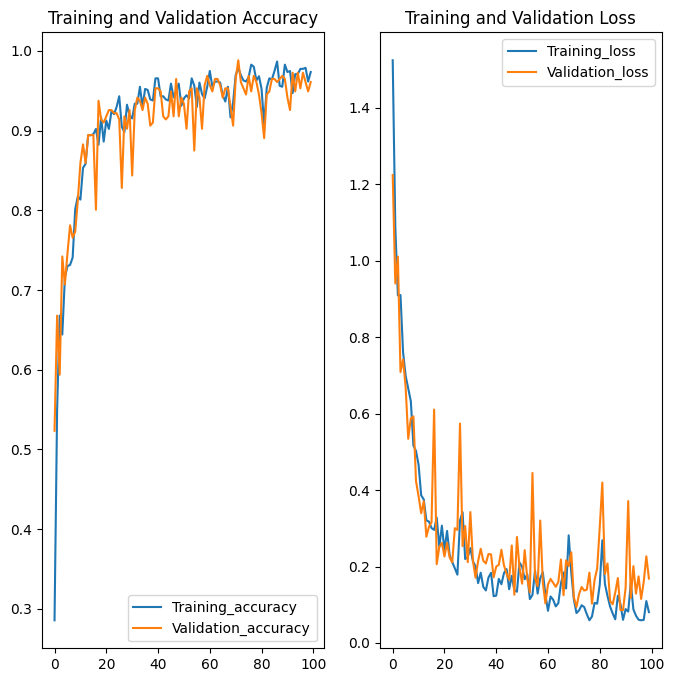

In [51]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training_accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation_accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training_loss')
plt.plot(range(EPOCHS),val_loss,label='Validation_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Disease:  Black soil
1/1 [==============================] - 0s 139ms/step
Predicted Disease:  Black soil


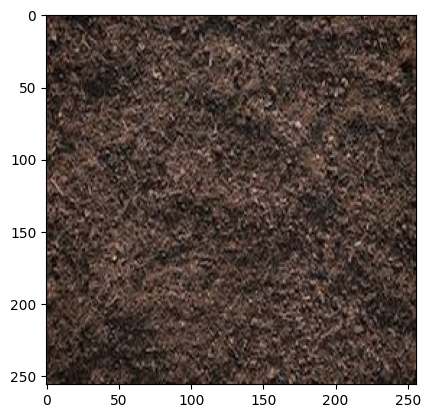

In [59]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Disease: ", class_names[labels_batch[0].numpy()])

    batch_predict=model.predict(images_batch)
    print("Predicted Disease: ",class_names[np.argmax(batch_predict[0])])


In [60]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    prediction=model.predict(img_array)
    predict_cls=class_names[np.argmax(prediction[0])]
    confidence=round(100 * (np.max(prediction[0])), 2)
    return predict_cls,confidence


In [61]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence= predict(model,images[i].numpy())

        actual_cls=class_names[labels[i]]
        plt.title(f"Actual: {actual_cls} \n Predicted : {predicted_class} \n Confidence : {confidence}%")
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [62]:
import os
model_version=max([int(i) for i in(os.listdir("/content/drive/MyDrive/Soil_Detection/model")+[0])])+1
model.save(f"/content/drive/MyDrive/Soil_Detection/model/{model_version}")